# 18.2.1 클래스

In [1]:
import numpy as np
import pandas as pd

from dx_frame import *
from sn_random_numbers import sn_random_numbers
from geometric_brownian_motion import geometric_brownian_motion
from jump_diffusion import jump_diffusion
from square_root_diffusion import square_root_diffusion
from simulation_class import simulation_class

from valuation_class import valuation_class
from valuation_mcs_european import valuation_mcs_european
from valuation_mcs_american import valuation_mcs_american

from derivatives_position import derivatives_position

In [2]:
# 위험 요인 모형화에 필요한 모형
models = {'gbm' : geometric_brownian_motion,
          'jd' : jump_diffusion,
          'srd' : square_root_diffusion}

# 행사 유형
otypes = {'European' : valuation_mcs_european,
          'American' : valuation_mcs_american}

class derivatives_portfolio(object):
    ''' 파생상품 포지션 포트폴리오 생성용 클래스
    
    속성
    ====
    name : str
        객체 이름
    positions : dict
        포지션용 사전(derivatives_position 클래스 인스턴스)
    val_env : market_environment
        가치 평가용 시장 환경
    assets : dict
        각 자산용 시장 환경 사전
    correlations : list
        자산간의 상관관계
    fixed_seed : Boolean
        랜덤 변수용 시드 플래그
    '''
    
    def __init__(self, name, positions, val_env, assets,correlations = None, fixed_seed = False):
        self.name = name
        self.positions = positions
        self.val_env = val_env
        self.assets = assets
        self.underlyings = set()
        self.correlations = correlations
        self.time_grid = None
        self.underlying_objects = {}
        self.valuation_objects = {}
        self.fixed_seed = fixed_seed
        self.special_dates = []
        
        for pos in self.positions:
            # 가장 빠른 starting_date 결정
            self.val_env.constants['starting_date'] = min(self.val_env.constants['starting_date'], positions[pos].mar_env.pricing_date)
            
            # 관련 있는 최신 날짜 결정
            self.val_env.constants['final_date'] = max(self.val_env.constants['final_date'], positions[pos].mar_env.constants['maturity'])
            
            # 모든 기초자산을 집합으로 모아서 중복 제거
            self.underlyings.add(positions[pos].underlying)
            
        # 시간 그리드 생성
        start = self.val_env.constants['starting_date']
        end = self.val_env.constants['final_date']
        time_grid = pd.date_range(start = start, end = end, freq = self.val_env.constants['frequency']).to_pydatetime()
        time_grid = list(time_grid)
        
        for pos in self.positions:
            maturity_date = positions[pos].mar_env.constants['maturity']
            
            if maturity_date not in time_grid:
                time_grid.insert(0, maturity_date)
                self.special_dates.append(maturity_date)
        
        if start not in time_grid:
            time_grid.insert(0, start)
        
        if end not in time_grid:
            time_grid.append(0, end)
        
        # 중복 요소 제거
        time_grid = list(set(time_grid))
        
        # time_grid 안의 날짜 정렬
        time_grid.sort()
        self.time_grid = np.array(time_grid)
        self.val_env.add_list('time_grid', self.time_grid)
        if correlations is not None:
            # 상관관계 계산
            ul_list = sorted(self.underlyings)
            correlation_matrix = np.zeros((len(ul_list), len(ul_list)))
            np.fill_diagonal(correlation_matrix, 1.0)
            correlation_matrix = pd.DataFrame(correlation_matrix, index = ul_list, columns = ul_list)
            
            for i, j, corr in correlations:
                corr = min(corr, 0.999999999999)
                correlation_matrix.loc[i, j] = corr
                correlation_matrix.loc[j, i] = corr
                
            # 숄레스키 행렬 계산
            cholesky_matrix = np.linalg.cholesky(np.array(correlation_matrix))
            
            # 각각의 기초자산과 랜덤 넘버 슬라이스에 대한 인덱스 위치 저장
            rn_set = {asset : ul_list.index(asset) for asset in self.underlyings}
            
            # (상관관계가 있는 경우) 모든 기초자산이 사용하는 랜덤 넘버 배열
            random_numbers = sn_random_numbers((len(rn_set), len(self.time_grid), self.val_env.constants['paths']), fixed_seed = self.fixed_seed)
            
            # 모든 기초자산이 공유하는 가치 계산용 환경 정보 추가
            self.val_env.add_list('cholesky_matrix', cholesky_matrix)
            self.val_env.add_list('random_numbers', random_numbers)
            self.val_env.add_list('rn_set', rn_set)
        
        for asset in self.underlyings:
            # 각 자산에 대한 시장 환경 선택
            mar_env = self.assets[asset]
            
            # 시장환경에 가치 계산용 환경 정보 추가
            mar_env.add_environment(val_env)
            
            # 시뮬레이션 클래스 선택
            model = models[mar_env.constants['model']]
            
            # 시뮬레이션 객체 생성
            if correlations is not None:
                self.underlying_objects[asset] = model(asset, mar_env, corr = True)
            
            else:
                self.underlying_objects[asset] = model(asset, mar_env, corr = False)
                
        for pos in positions:
            # 가치평가 클래스 선택
            val_class = otypes[positions[pos].otype]
            
            # 시장 환경 및 가치 계산용 환경 선택
            mar_env = positions[pos].mar_env
            mar_env.add_environment(self.val_env)
            
            # 가치 평가용 클래스 인스턴스 생성
            self.valuation_objects[pos] = val_class(name = positions[pos].name,
                                                    mar_env = mar_env, 
                                                    underlying = self.underlying_objects[positions[pos].underlying], 
                                                    payoff_func = positions[pos].payoff_func)
    
    def get_positions(self):
        ''' 포트폴리오 내의 모든 파생상품 포지션에 대한 정보를 얻기 위한 Method
        '''
        for pos in self.positions:
            bar = '\n' + 50 * '-'
            print(bar)
            
            self.positions[pos].get_info()
            print(bar)
            
    def get_statistics(self, fixed_seed = False):
        ''' 포트폴리오 통계 제공 '''
        res_list = []
        
        # 포트폴리오 내의 모든 포지션에 대해 반복
        for pos, value in self.valuation_objects.items():
            p = self.positions[pos]
            pv = value.present_value(fixed_seed = fixed_seed)
            res_list.append([p.name,
                             p.quantity,
                             pv,
                             value.currency,
                             pv * p.quantity,
                             value.delta() * p.quantity,
                             value.vega() * p.quantity])
        res_df = pd.DataFrame(res_list, columns = ['name', 'quant', 'value', 'curr.',
                                                       'pos_value', 'pos_delta', 'pos_vega'])
        return res_df
            

# 18.2.2 사용법

In [3]:
me_gbm = market_environment('me_gbm', dt.datetime(2015, 1, 1))

In [4]:
me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('currency', 'EUR')

In [5]:
me_gbm.add_constant('model', 'gbm')

In [6]:
me_am_put = market_environment('me_am_put', dt.datetime(2015, 1, 1))

In [7]:
me_am_put.add_constant('maturity', dt.datetime(2015, 12, 31))
me_am_put.add_constant('strike', 40.)
me_am_put.add_constant('currency', 'EUR')

In [8]:
payoff_func = 'np.maximum(strike - instrument_values, 0)'

In [9]:
am_put_pos = derivatives_position(name = 'am_put_pos',
                                 quantity = 3,
                                 underlying = 'gbm',
                                 mar_env = me_am_put,
                                 otype = 'American',
                                 payoff_func = payoff_func)

In [10]:
am_put_pos.get_info()

NAME
am_put_pos 

QUANTITY
3 

UNDERLYING
gbm 

MARKET ENVIRONMENT

**Lists**
maturity 2015-12-31 00:00:00
strike 40.0
currency EUR

**Curves**

OPTION TYPE
American 

PAYOFF FUNCTION
np.maximum(strike - instrument_values, 0)


In [11]:
me_jd = market_environment('me_jd', me_gbm.pricing_date)

In [12]:
me_jd.add_constant('lambda', 0.3)
me_jd.add_constant('mu', -0.75)
me_jd.add_constant('delta', 0.1)
me_jd.add_environment(me_gbm)

In [13]:
me_jd.add_constant('model', 'jd')

In [14]:
me_eur_call = market_environment('me_eur_call', me_jd.pricing_date)

In [15]:
me_eur_call.add_constant('maturity', dt.datetime(2015, 6, 30))
me_eur_call.add_constant('strike', 38.)
me_eur_call.add_constant('currency', 'EUR')

In [16]:
payoff_func = 'np.maximum(maturity_value - strike, 0)'

In [17]:
eur_call_pos = derivatives_position(name = 'eur_call_pos',
                                   quantity = 5,
                                   underlying = 'jd',
                                   mar_env = me_eur_call,
                                   otype = 'European',
                                   payoff_func = payoff_func)

In [18]:
# 포트폴리오 관점에서 필요한 시장 정보
underlyings = {'gbm' : me_gbm, 'jd' : me_jd}
positions = {'am_put_pos' : am_put_pos, 'eur_call_pos' : eur_call_pos}

In [19]:
# 기초자산 간의 상관관계 모형화
# derivatives_portfolio 클래스 인트턴스를 만들기 위한 포트폴리오에 필요한 market_environment 생성
# 가치평가를 위한 할인 객체
csr = constant_short_rate('csr', 0.06)

In [20]:
val_env = market_environment('general', me_gbm.pricing_date)

In [21]:
val_env.add_constant('frequency', 'W')
# 주간 단위
val_env.add_constant('paths', 25000)
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', val_env.pricing_date)
# 임시로 pricing_date 사용
val_env.add_curve('discount_curve', csr)

In [22]:
# form derivatives_portfolio import derivatives_portfolio
portfolio = derivatives_portfolio(name = 'portfolio',
                                  positions = positions,
                                  val_env = val_env,
                                  assets = underlyings,
                                  fixed_seed = True)

In [23]:
portfolio.get_statistics()

,name,quant,value,curr.,pos_value,pos_delta,pos_vega
0,am_put_pos,3,4.623340,EUR,13.87002,-1.9590,39.7911
1,eur_call_pos,5,2.899164,EUR,14.49582,3.4615,44.0750


In [24]:
portfolio.get_statistics()[['pos_value', 'pos_delta', 'pos_vega']].sum()

pos_value    28.463127
pos_delta     1.367500
pos_vega     83.866100
dtype: float64

In [25]:
portfolio.get_positions()


--------------------------------------------------
NAME
am_put_pos 

QUANTITY
3 

UNDERLYING
gbm 

MARKET ENVIRONMENT

**Lists**
maturity 2015-12-31 00:00:00
strike 40.0
currency EUR
frequency W
paths 25000
starting_date 2015-01-01 00:00:00
final_date 2015-12-31 00:00:00

**Curves**
final_date 2015-12-31 00:00:00

OPTION TYPE
American 

PAYOFF FUNCTION
np.maximum(strike - instrument_values, 0)

--------------------------------------------------

--------------------------------------------------
NAME
eur_call_pos 

QUANTITY
5 

UNDERLYING
jd 

MARKET ENVIRONMENT

**Lists**
maturity 2015-06-30 00:00:00
strike 38.0
currency EUR
frequency W
paths 25000
starting_date 2015-01-01 00:00:00
final_date 2015-12-31 00:00:00

**Curves**
final_date 2015-12-31 00:00:00

OPTION TYPE
European 

PAYOFF FUNCTION
np.maximum(maturity_value - strike, 0)

--------------------------------------------------


In [26]:
portfolio.valuation_objects['am_put_pos'].present_value()

4.655769

In [27]:
portfolio.valuation_objects['eur_call_pos'].delta()

0.6693

In [28]:
path_no = 777
path_gbm = portfolio.underlying_objects['gbm'].get_instrument_values()[:, path_no]
path_jd = portfolio.underlying_objects['jd'].get_instrument_values()[:, path_no]

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

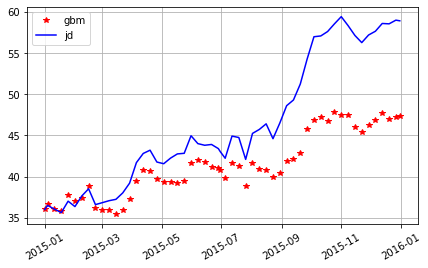

In [45]:
plt.figure(figsize = (7, 4))
plt.plot(portfolio.time_grid, path_gbm, 'r', label = 'gbm')
plt.plot(portfolio.time_grid, path_jd, 'b', label = 'jd')
plt.xticks(rotation = 30)
plt.legend(loc = 0)
plt.grid(True)

In [31]:
# 상관관계가 있을경우
correlations = [['gbm', 'jd', 0.9]]

In [32]:
# 상관관계를 추가하여 새로운 derivatives_portfolio 객체 생성
port_corr = derivatives_portfolio(name = 'portfolio',
                                  positions = positions,
                                  val_env = val_env,
                                  assets = underlyings,
                                  correlations = correlations,
                                  fixed_seed = True)

In [33]:
port_corr.get_statistics()
# 각 포지션의 가치에는 영향 없음

,name,quant,value,curr.,pos_value,pos_delta,pos_vega
0,am_put_pos,3,4.619792,EUR,13.859376,-1.9284,40.7187
1,eur_call_pos,5,2.888685,EUR,14.443425,3.4775,43.6220


In [34]:
path_gbm = port_corr.underlying_objects['gbm'].get_instrument_values()[:, path_no]
path_jd = port_corr.underlying_objects['jd'].get_instrument_values()[:, path_no]

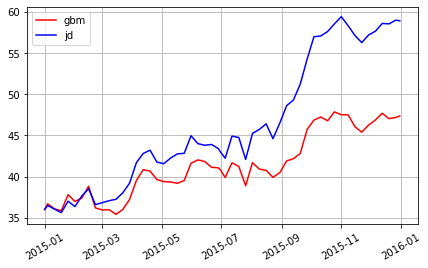

In [35]:
plt.figure(figsize = (7, 4))
plt.plot(portfolio.time_grid, path_gbm, 'r', label = 'gbm')
plt.plot(portfolio.time_grid, path_jd, 'b', label = 'jd')
plt.xticks(rotation = 30)
plt.legend(loc = 0)
plt.grid(True)

In [36]:
# 포트폴리오의 현재가치에 대한 분포
pv1 = 5 * port_corr.valuation_objects['eur_call_pos'].present_value(full = True)[1]

In [37]:
pv1

array([ 0.        , 40.46758828, 24.54420555, ...,  0.        ,
        6.5125118 ,  8.18851653])

In [38]:
pv2 = 3 * port_corr.valuation_objects['am_put_pos'].present_value(full = True)[1]

In [39]:
pv2

array([22.33631582, 12.1476107 , 20.33098087, ..., 22.01996731,
       12.9969704 ,  0.        ])

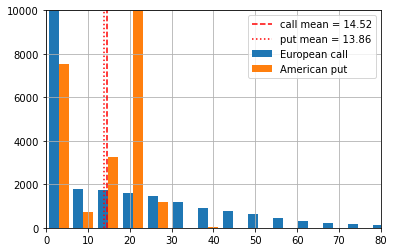

In [40]:
plt.hist([pv1, pv2], bins = 25, label = ['European call', 'American put'])
plt.axvline(pv1.mean(), color = 'r', ls = 'dashed', lw = 1.5, label = 'call mean = %4.2f' % pv1.mean())
plt.axvline(pv2.mean(), color = 'r', ls = 'dotted', lw = 1.5, label = 'put mean = %4.2f' % pv2.mean())
plt.xlim(0, 80)
plt.ylim(0, 10000)
plt.grid()
plt.legend()

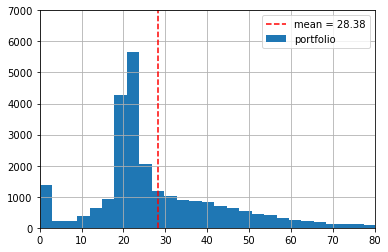

In [41]:
pvs = pv1 + pv2
plt.hist(pvs, bins = 50, label = 'portfolio')
plt.axvline(pvs.mean(), color = 'r', ls = 'dashed', lw = 1.5, label = 'mean = %4.2f' % pvs.mean())
plt.xlim(0, 80)
plt.ylim(0, 7000)
plt.grid()
plt.legend()

In [42]:
# 상관관계가 있는 포트폴리오의 변동성 
pvs.std()

16.958325400506318

In [43]:
# 상관관계가 없는 포트폴리오의 변동성
pv1 = 5 * portfolio.valuation_objects['eur_call_pos'].present_value(full = True)[1]
pv2 = 3 * portfolio.valuation_objects['am_put_pos'].present_value(full = True)[1]

In [44]:
(pv1 + pv2).std()

22.862366370089898

상관관계가 증가하면 평균값은 거의 그대로지만 전체 변동성은 크게 감소함!